# <a id='toc1_'></a>[ARIMA](#toc0_)
-----

**Table of contents**<a id='toc0_'></a>    
- [ARIMA](#toc1_)    
- [Preprocessing and tests](#toc2_)    
  - [Set Path](#toc2_1_)    
  - [ADF Test](#toc2_2_)    
  - [Diff data and remove outliers](#toc2_3_)    
  - [Test Stationarity again](#toc2_4_)    
  - [Split data into train and test](#toc2_5_)    
  - [Show Distribution](#toc2_6_)    
  - [PACF & ACF plots](#toc2_7_)    
  - [Plot Diff Data](#toc2_8_)    
  - [Ljung-Box Test for Serial Correlation (White Noise)](#toc2_9_)    
- [Model Initialization](#toc3_)    
  - [Initaite the model – Grid Search 10x10](#toc3_1_)    
  - [Heat Map](#toc3_2_)    
  - [White Noise test for model residuals](#toc3_3_)    
  - [30-Day Forecast](#toc3_4_)    
  - [Model Metrics](#toc3_5_)    
  - [Random Walk and Prediction of the next value](#toc3_6_)    
  - [Pure Value for Random Walk](#toc3_7_)    
  - [Plot the prediction along with the actual data and random walk](#toc3_8_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[Preprocessing and tests](#toc0_)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from pmdarima import auto_arima
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.diagnostic import acorr_ljungbox
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tabulate import tabulate
import LSTMpy as lstm


# Dependencies for used functions
import arima as ar

## set random seed
np.random.seed(42)

%matplotlib inline
%load_ext autoreload


In [2]:
## Choose name for column (Used Later in Script)
column = "SEKDKK"

data = pd.read_csv("20_year_data.csv", delimiter=";")

data['Date'] = pd.to_datetime(data['Date'], format = '%d/%m/%Y')
data = data.set_index('Date')

data = data.replace(to_replace=",", value=".", regex=True)

## Convert all columns to float using regex
data = data.replace(to_replace="[^0-9.]", value="", regex=True)

## Convert all columns to numeric 
data = data.apply(pd.to_numeric)

## choose only the "Value" column with iloc
data = data.iloc[:, 2:3]

data



            SEKDKK
Date              
2020-06-30  0.7111
2020-07-01  0.7125
2020-07-02  0.7127
2020-07-03  0.7118
2020-07-06  0.7088
...            ...
2023-04-20  0.6572
2023-04-21  0.6578
2023-04-24  0.6578
2023-04-25  0.6592
2023-04-26  0.6573

[716 rows x 1 columns]
(716, 1)
0


/Users/vg/Desktop/Model – BA/LSTMpy.py:19: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data["Date"] = pd.to_datetime(data["Date"])


## <a id='toc2_1_'></a>[Set Path](#toc0_)

In [3]:
import os
if not os.path.exists(f"ARIMA {column}"):
    os.makedirs(f"ARIMA {column}")

# set the path the folder where the models are saved

pwd = os.getcwd()

path = pwd + f"/ARIMA {column}/"

print(path)

/Users/vg/Desktop/Model – BA/ARIMA SEKDKK/


## <a id='toc2_2_'></a>[ADF Test](#toc0_)

In [4]:
# Adf Test
ar.test_stationarity(data.values, column, "before")

ADF Statistic: -0.6162723877462907
p-value: 0.8672625788236459
Critical Values:
	1%: -3.4395289262948894
	5%: -2.8655907692307694
	10%: -2.5689271030368235
The series is not stationary
\begin{tabular}{lr}
\hline
 ADF Statistic                                                    & -0.616272 \\
 p-value                                                          &  0.867263 \\
 1\%                                                               & -3.43953  \\
 5\%                                                               & -2.86559  \\
 10\%                                                              & -2.56893  \\
 The series is not stationary as the p-value is greater than 0.05 &           \\
\hline
\end{tabular}


## <a id='toc2_3_'></a>[Diff data and remove outliers](#toc0_)

In [5]:
## Diff data to make it stationary and remove outliers
ar.diff_outliers(data, column)

diff_data = ar.diff_outliers(data, column)

\begin{tabular}{lr}
\hline
 Removed outliers             &   1 \\
 Total number of observations & 716 \\
\hline
\end{tabular}
\begin{tabular}{lr}
\hline
 Removed outliers             &   1 \\
 Total number of observations & 716 \\
\hline
\end{tabular}


## <a id='toc2_4_'></a>[Test Stationarity again](#toc0_)

In [6]:
ar.test_stationarity(diff_data.values, column, "after")

ADF Statistic: -15.832045333688123
p-value: 9.917136398930727e-29
Critical Values:
	1%: -3.4395677423210493
	5%: -2.8656078730509784
	10%: -2.5689362152032573
The series is stationary
\begin{tabular}{lr}
\hline
 ADF Statistic                                             & -15.832       \\
 p-value                                                   &   9.91714e-29 \\
 1\%                                                        &  -3.43957     \\
 5\%                                                        &  -2.86561     \\
 10\%                                                       &  -2.56894     \\
 The series is stationary as the p-value is less than 0.05 &               \\
\hline
\end{tabular}


## <a id='toc2_5_'></a>[Split data into train and test](#toc0_)

In [7]:
## Split into train and test
data_train = diff_data[:-30]
data_test = diff_data[-30:]

print(data_train.shape)
print(data_test.shape)

(685, 1)
(30, 1)


## <a id='toc2_6_'></a>[Show Distribution](#toc0_)

/Users/vg/Desktop/Model – BA/arima.py:105: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mean = float(mean)
/Users/vg/Desktop/Model – BA/arima.py:118: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(diff_data, hist=True, kde=True, bins=30, color='b', hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 2}, label = "True Distribution")


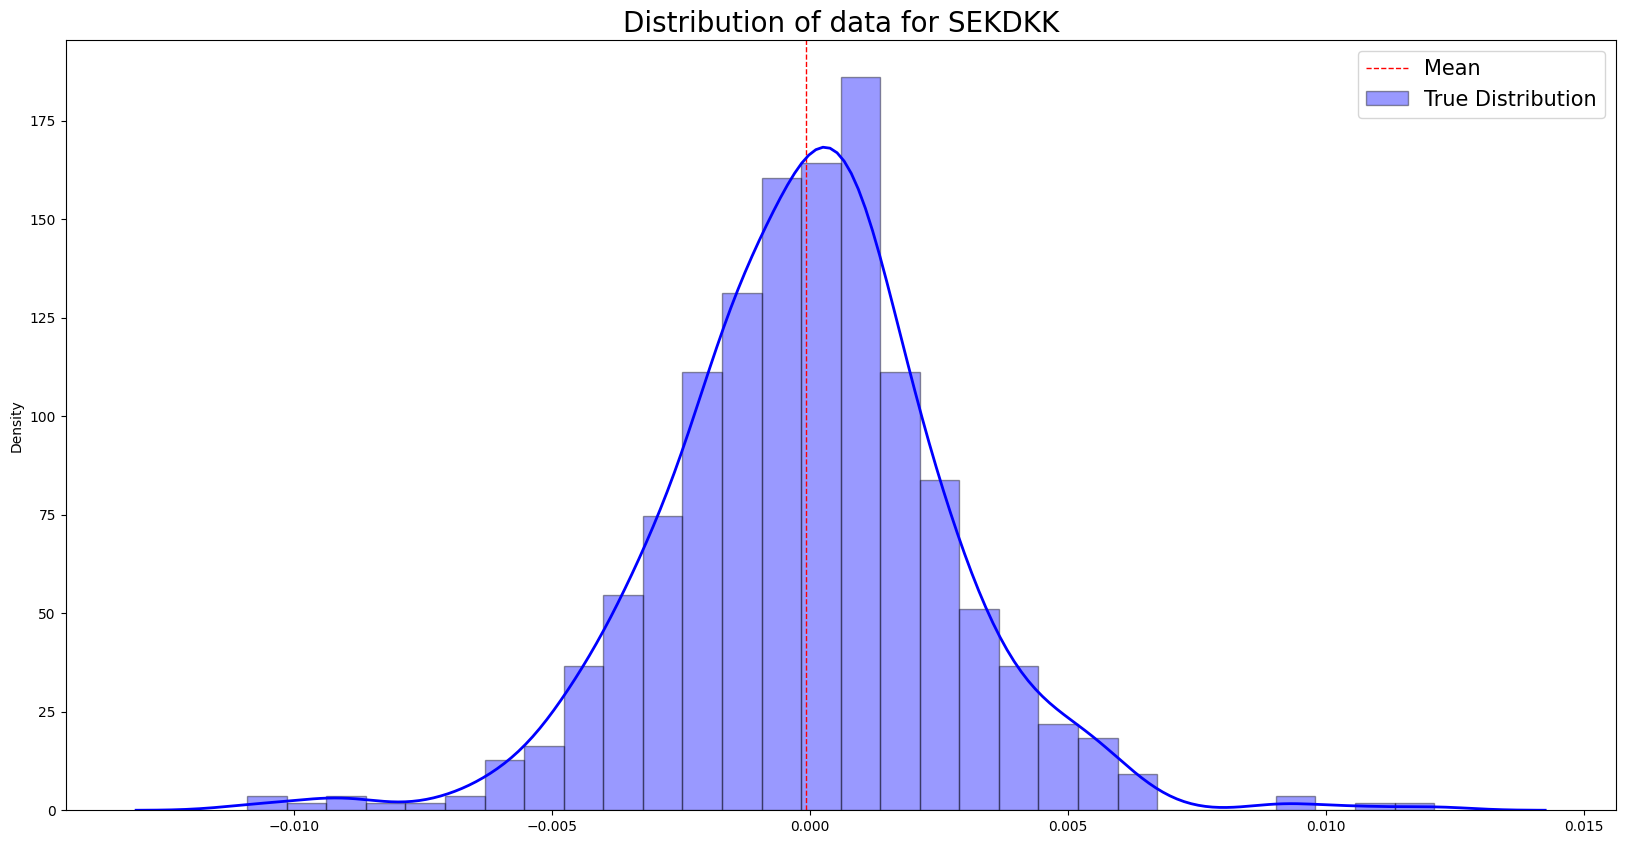

In [8]:
ar.distribution(diff_data, column)

## <a id='toc2_7_'></a>[PACF & ACF plots](#toc0_)


/Users/vg/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


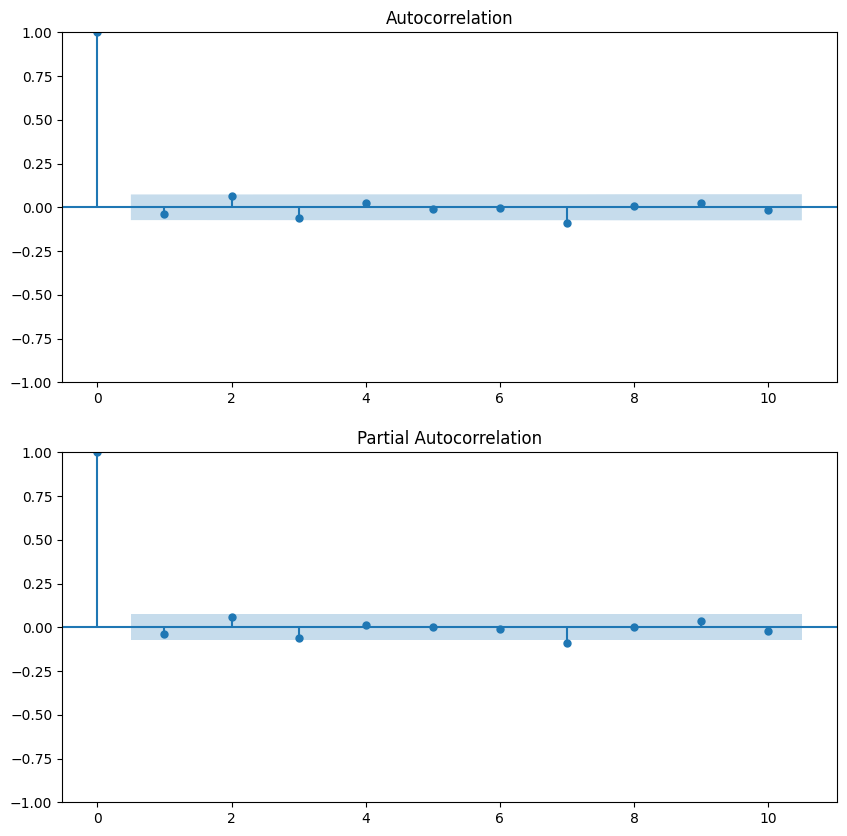

In [9]:
## plot acf and pacf in a 2x1 grid for the diff_data
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
sm.graphics.tsa.plot_acf(diff_data.values.squeeze(), lags=10, ax=plt.gca())
plt.subplot(2,1,2)
sm.graphics.tsa.plot_pacf(diff_data.values.squeeze(), lags=10, ax=plt.gca())

## Save fig to path
plt.savefig(f"ARIMA {column}_acf_pacf.png")

plt.show()

## <a id='toc2_8_'></a>[Plot Diff Data](#toc0_)

/var/folders/zn/8wl2ftxd7sg0pjvzvx59s5xr0000gn/T/ipykernel_62361/1259227053.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mean = float(mean)
/Users/vg/Desktop/Model – BA/arima.py:143: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mean = float(mean)


-7.524475524475519e-05


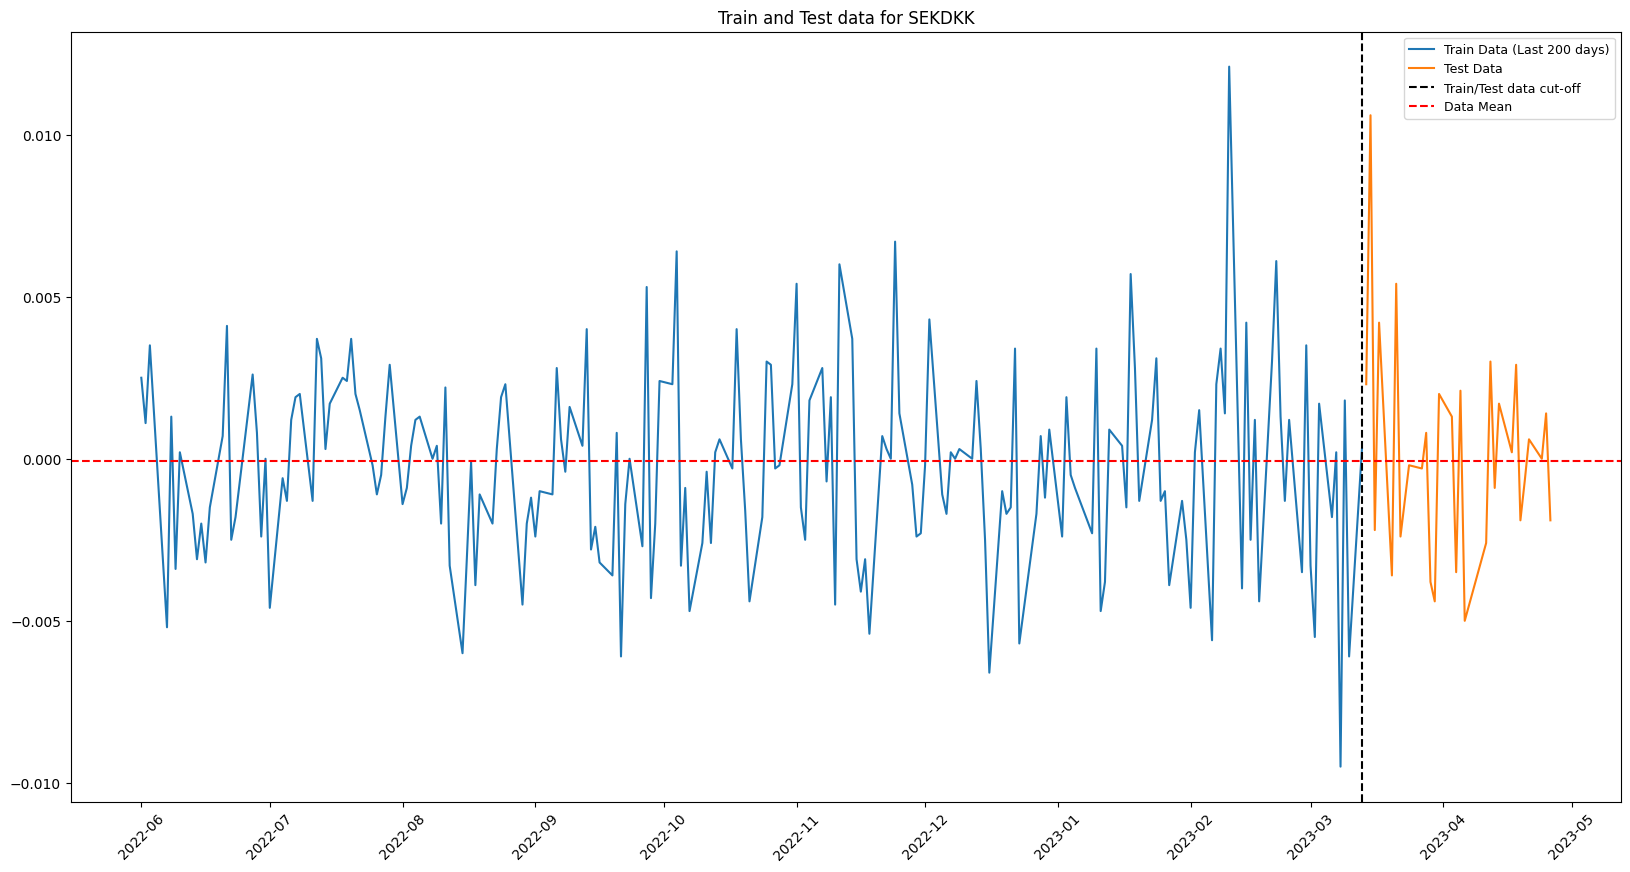

In [10]:
mean = diff_data.mean()
mean = float(mean)

ar.plot_all(data_train, data_test, diff_data, column, mean)

## <a id='toc2_9_'></a>[Ljung-Box Test for Serial Correlation (White Noise)](#toc0_)

In [21]:
## run the function
ar.white_noise(data, 1, ["Lags", "P-Value Data"])


The p-value from the white noise test is 1.8015579492416868e-155
The data is not white noise
\begin{tabular}{ll}
\hline
 Lags   & P-Value Data            \\
\hline
 Lag    & p-value                 \\
 1      & 1.8015579492416868e-155 \\
\hline
\end{tabular}


1.8015579492416868e-155

# <a id='toc3_'></a>[Model Initialization](#toc0_)

## <a id='toc3_1_'></a>[Initaite the model – Grid Search 10x10](#toc0_)

In [22]:
model, aic_matrix, p, q = ar.model_initialise(data_train, data_test, column, mean, diff_data)

 40%|████      | 4/10 [00:20<00:31,  5.24s/it]

## <a id='toc3_2_'></a>[Heat Map](#toc0_)

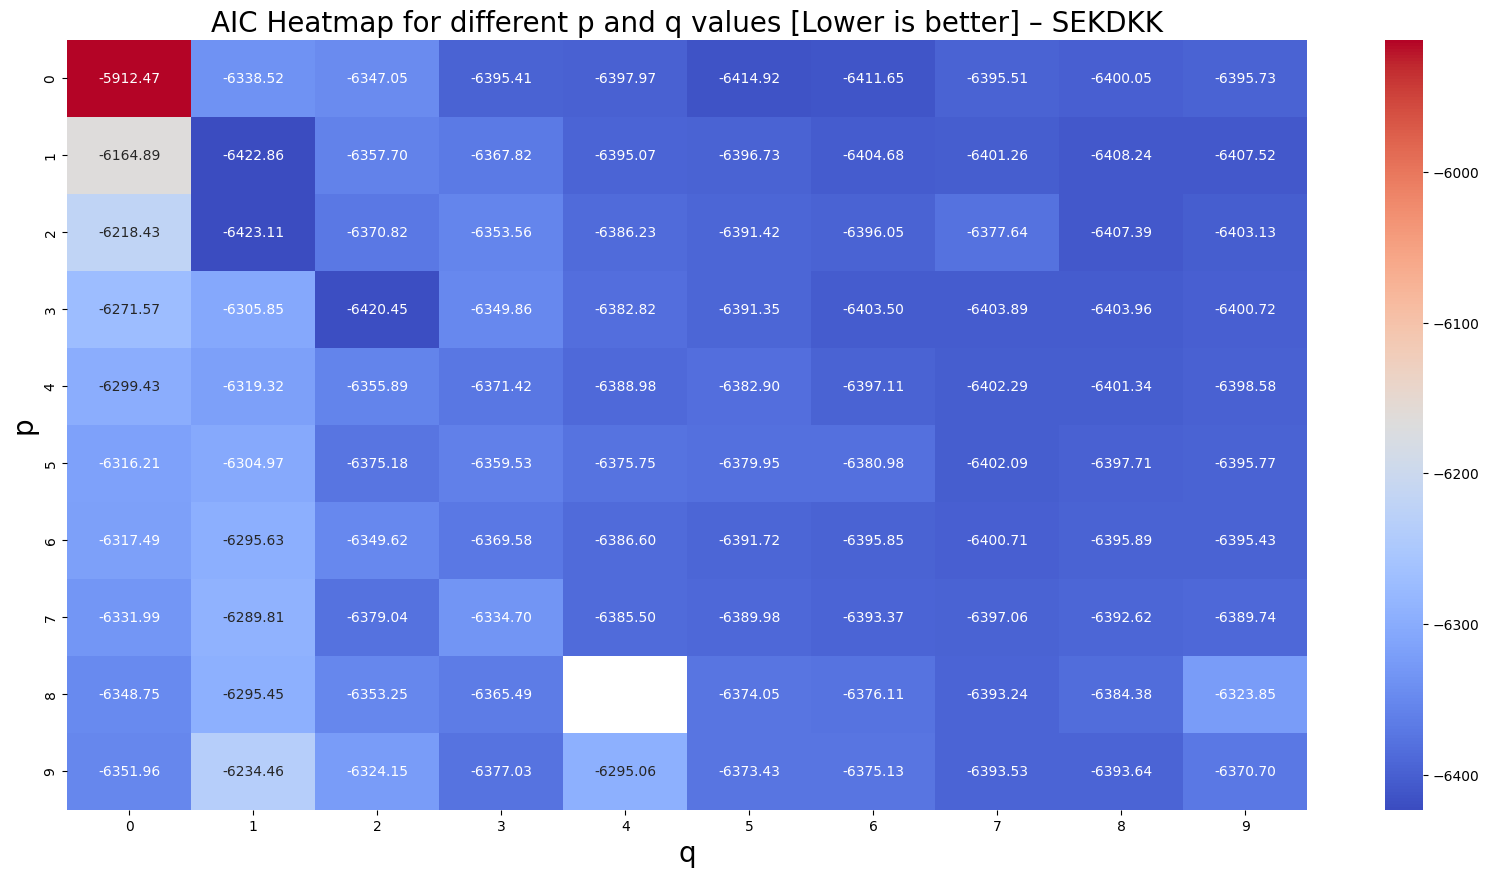

The best p and q values are
(array([2]), array([1]))


In [13]:
ar.heatmap(aic_matrix, column)

In [14]:
## model summary for the best model which draws from the heatmap
# get p and q value for the best model
p = aic_matrix.argmin()//10
q = aic_matrix.argmin()%10

model = sm.tsa.ARIMA(diff_data, order=(p,1,q)).fit()

# print summary in latex
print(model.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}          &      SEKDKK      & \textbf{  No. Observations:  } &    715      \\
\textbf{Model:}                  &  ARIMA(2, 1, 1)  & \textbf{  Log Likelihood     } &  3215.554   \\
\textbf{Date:}                   & Wed, 03 May 2023 & \textbf{  AIC                } & -6423.108   \\
\textbf{Time:}                   &     00:12:58     & \textbf{  BIC                } & -6404.824   \\
\textbf{Sample:}                 &        0         & \textbf{  HQIC               } & -6416.047   \\
\textbf{}                        &       - 715      & \textbf{                     } &             \\
\textbf{Covariance Type:}        &       opg        & \textbf{                     } &             \\
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
                & \textbf{coef} & \textbf{std err} & \textbf{z} & \textbf{P$> |$z$|$} & \textbf{[0.025} & \textbf{0.975]}  \\
\midrule
\textbf{ar.L1}  &      -0.0389  &        0.037     &  

## <a id='toc3_3_'></a>[White Noise test for model residuals](#toc0_)

In [15]:
import importlib
importlib.reload(ar)

## find residuals for the model
residuals = model.resid

ar.white_noise(residuals, 1, ["Lags", "P-Value Residuals"])

The p-value from the white noise test is 0.890642865503831
The data is white noise
\begin{tabular}{ll}
\hline
 Lags   & P-Value Residuals   \\
\hline
 Lag    & p-value             \\
 1      & 0.890642865503831   \\
\hline
\end{tabular}


0.890642865503831

## <a id='toc3_4_'></a>[30-Day Forecast](#toc0_)

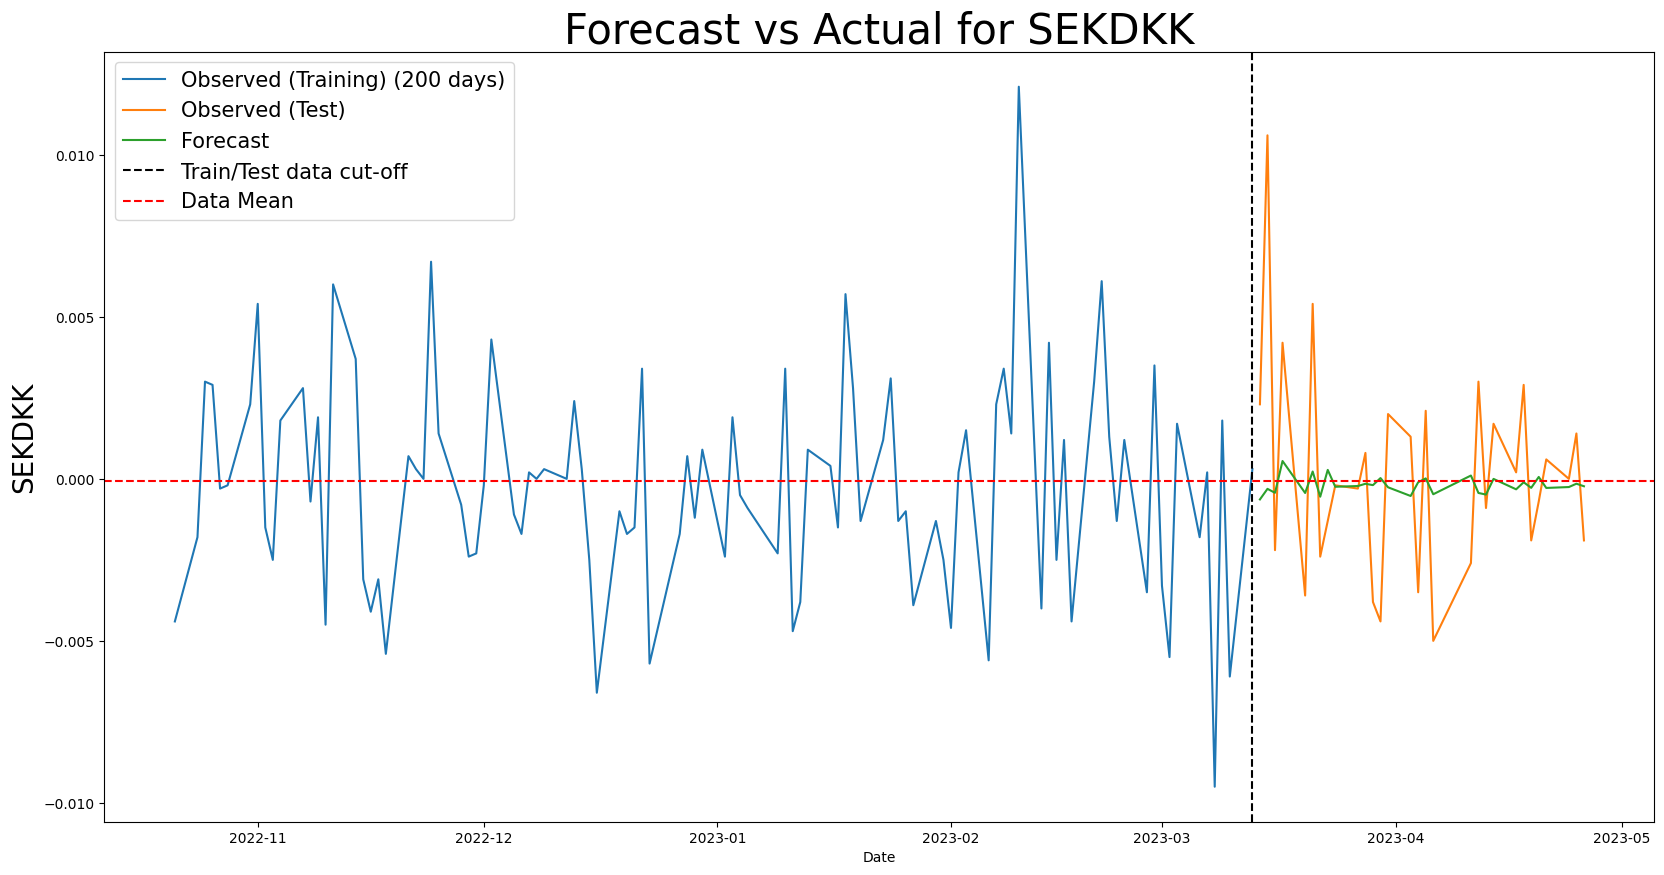

In [16]:
y_train = data_train
y_test = data_test

forecast = ar.plot_forecast_comparison(model, y_train, y_test, column, mean, steps=30)

## <a id='toc3_5_'></a>[Model Metrics](#toc0_)

In [17]:
forecast = model.predict(n_periods=30)
forecast = pd.Series(forecast, index=data_test.index)
test = diff_data[-30:]

## Save table to latex with, title headers and name
table = ar.get_metrics(test, forecast)
name = ["Metric", "Value"]
    
with open(f"ARIMA {column}_metrics_forecast.tex", "w") as f:
    f.write(tabulate(table, tablefmt="latex", headers = name))  

\begin{tabular}{lr}
\hline
 R2   & 0.0107417  \\
 MSE  & 1.0192e-05 \\
 MAE  & 0.00242479 \\
 MAPE & 3.7959e+10 \\
 RMSE & 0.00319248 \\
\hline
\end{tabular}


## <a id='toc3_6_'></a>[Random Walk and Prediction of the next value](#toc0_)

In [18]:
random_walk, df, table_concat = ar.direction_counter(forecast, test, column)

\begin{tabular}{lll}
\hline
                                  & ARIMA SEKDKK   & Random walk   \\
\hline
 Total number of predictions      & 29             & 29            \\
 Number of correct directions     & 21             & 10            \\
 Number of false directions       & 9              & 20            \\
 Percentage of correct directions & 72.41\%         & 34.48\%        \\
 Percentage of false directions   & 27.59\%         & 65.52\%        \\
\hline
\end{tabular}


## <a id='toc3_7_'></a>[Pure Value for Random Walk](#toc0_)

In [19]:
# see Directional Predictive Ability (DPA) for the model and the random walk
## create a data frame with forecast, random walk and actual values

ar.rand(random_walk, forecast, data_test, column)

\begin{tabular}{ll}
\hline
                                  & Random walk   \\
\hline
 Counter                          & 30            \\
 Total number of predictions      & 30            \\
 Number of correct directions     & 10            \\
 Number of false directions       & 20            \\
 Percentage of correct directions & 33.33\%        \\
 Percentage of false directions   & 66.67\%        \\
\hline
\end{tabular}


## <a id='toc3_8_'></a>[Plot the prediction along with the actual data and random walk](#toc0_)

<Figure size 2000x1000 with 0 Axes>

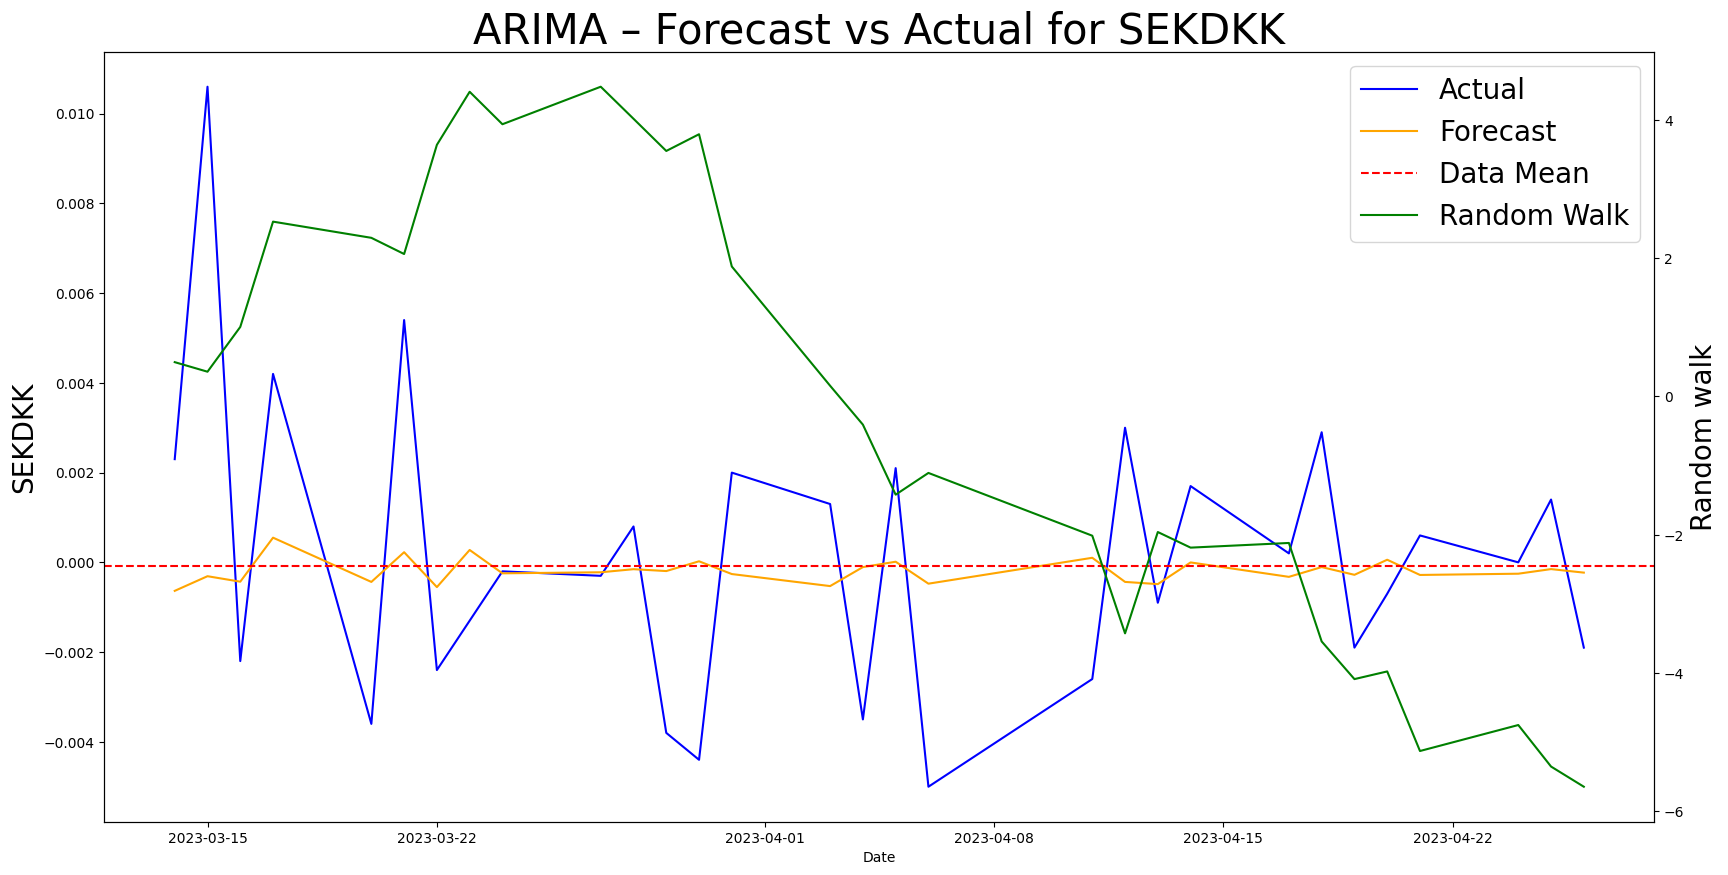

In [20]:
import importlib
importlib.reload(ar)

ar.actual_forecat_random(random_walk, data_test, column, mean, model, y_test, 30)